# Captcha Challenge

- Environment Requirement: Python 3.5, TensorFlow 1.2, Keras 2.0

In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

### 生成字符集

In [2]:
# 获得字符集（共36种可能）
import string
characters = string.digits + string.ascii_uppercase
print(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


### 生成样本图像

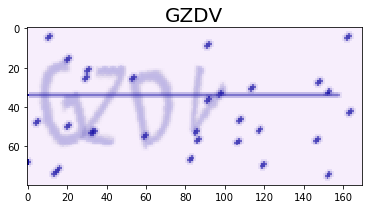

Image Shape : (80, 170, 3)


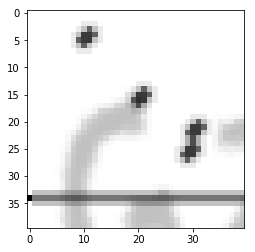

In [3]:
# 图像尺寸长与宽
width, height = 170, 80
# 所含字符个数
n_len = 4
# 所用字符集大小
n_class = len(characters)

# Captcha生成器对象
generator = ImageCaptcha(width, height)
random_str = ''.join([random.choice(characters) for i in range(n_len)])
img = generator.generate_image(random_str)
plt.imshow(img)
plt.title(random_str, fontsize=20)
plt.show()

# 转为np矩阵,裁切图片
img_matrix = np.array(img)
print("Image Shape :", img_matrix.shape)
plt.imshow(img_matrix[:40, :40, 0], cmap='gray')
plt.show()

### 批量图片生成器与解码

- 具有 `yield` 关键字的函数就不再是一个普通的函数，而是一个生成器（Generator）。


- 使用时，需要：

    - 先创建该生成器的对象：`gen = generator()`
    - 然后使用 `next()` 方法调用这个对象：`next(gen)`
    - 或者使用循环语句：`for x in gen: xxx`
    
    
- 批量图片生成函数：给定要生成的图片集大小 `batch_size`，每调用一次 `next` 就生成 `batch_size` 这么多长图片。

    - 初始化返回值的时候使用np.uint8，无符号正数，取值范围[0, 255]。刚好对应图像的灰度值。


- 返回值

    - X 是四维np数组，[batch_size, height, width, RGB]。第一维表示图片个数。
    - Y 是长度为4的list，每个元素表示图片里的一个字符。list里面存的是二维np数组，[batch_size, n_class]。

SZL8


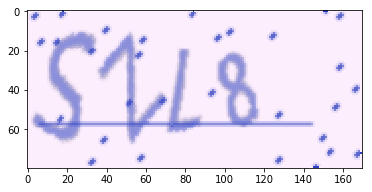

In [4]:
# X store image batches
# Y store text batches
def generate_batch(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    Y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    img_gen = ImageCaptcha(width, height)
    
    # 无限生成图片集（每次调用时都从Yield的下一句开始）
    while True:
        for pic_id in range(batch_size):
            random_str = ''.join([random.choice(characters) for i in range(n_len)])
            X[pic_id] = img_gen.generate_image(random_str) 
            for i, ch in enumerate(random_str):
                Y[i][pic_id, :] = 0                      # Reset
                Y[i][pic_id, characters.find(ch)] = 1    # Set (One-hot Encoding Label)
        yield X, Y

        
# 用于解码OLE编码的文本信息，还原成字符串
def decode(y):
    y = np.argmax(np.array(y), axis=2)
    y = y[:,0]
    return ''.join([characters[x] for x in y])


X, y = next(generate_batch(10))
plt.imshow(X[0])
print(decode(y))

### 基于VGG16创建CNN模型

In [32]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Convolution2D, MaxPool2D, MaxPooling2D, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
# 别名
# Conv2D = Convolution2D
# MaxPool2D = MaxPooling2D

In [34]:
def create_model_BN(num_CCM, num_kernel):
    # Input Layers
    input_tensor = Input((height, width, 3))
    x = input_tensor

    for i in range(num_CCM):
        conv_num_output = num_kernel * (2**i)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPool2D(pool_size=2, strides=2, padding='valid')(x)
    # Flatten
    x = Flatten()(x)
    # Dropout
    x = Dropout(0.25)(x)
    # Fully-Connected Layer (由于需要识别的字符数量是4，因此需要用4个全链接子网)
    x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]

    model = Model(inputs=input_tensor, outputs=x, name='captcha')
    return model

In [6]:
# CCM -> CCM -> CCM -> CCM -> Flatten -> Dropout -> Fully-Connected X 4 -> output
def create_model(num_CCM, num_kernel):
    # Input Layers
    input_tensor = Input((height, width, 3))
    x = input_tensor

    # Convolution + Pooling Layer (4层CCM级联，模拟VGG16的结构)
    # 32C 32C M -> 64C 64C M -> 128C 128C M -> 256C 256C M
    for i in range(num_CCM):
        conv_num_output = num_kernel * (2**i)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = MaxPool2D(pool_size=2, strides=2, padding='valid')(x)
    # Flatten
    x = Flatten()(x)
    # Dropout
    x = Dropout(0.25)(x)
    # Fully-Connected Layer (由于需要识别的字符数量是4，因此需要用4个全链接子网)
    x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]

    model = Model(inputs=input_tensor, outputs=x, name='captcha')
    return model

### 开始训练模型

#### 基本流程

1. 建立模型：create
2. 转换模型：make_parallel
3. 编译模型：compile
4. 训练模型：fit_generator
5. 验证模型：predict

### 使用 fit_generator 训练

- fit 与 fit_generator 都是用来训练模型的API，区别在于：

    - `fit` 的训练数据集是现成的，训练的过程中只需要每次读进来一批就行了
    - `fit_generator` 的训练数据是实时生成的，需要提前指定好生成器，然后每一代训练的时候通过先调用生成器生产训练数据，之后再训练。

In [35]:
from helper import make_parallel
from keras.callbacks import EarlyStopping, TensorBoard, History

# 1. Create Model (4 CCM)
model = create_model_BN(4, 32)

# 2. Enable Data Parallelism
# model = make_parallel(model, 2)

# 3. Compile Model with metrics/optimizer/loss
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

#### 可以反复运行下面的Cell来累积的重复训练同一个模型

In [ ]:
# the number of samples processed for each epoch is batch_size * steps_per_epochs
batch_size = 64
epoch = 5

# Training Set for one epoch
train_samples = 51200
train_steps = train_samples / batch_size

# Validation Set for one epoch
validation_sample = train_samples * 0.02
validation_steps = validation_sample / batch_size

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)

# TensorBoard
# To be figured out...

# History：用来保存每一代的训练结果，以供训练结束后画图看趋势
his = History()

# Start training
model.fit_generator(generate_batch(batch_size), 
                    steps_per_epoch=train_steps, 
                    epochs=epoch, 
                    validation_data=generate_batch(128), 
                    validation_steps=validation_steps,
                    callbacks=[early_stopping])

In [49]:
# 保存模型(需要安装h5py)
model.save('my_model_20epoch.h5')
model.save_weights("captcha_20epoch")

In [59]:
del model

In [60]:
# 重新载入模型
import tensorflow as tf
from keras.models import load_model
model = load_model('my_model_20epoch.h5')

### 测试模型性能

- 首先，图片生成器的真实输出（y_true）和模型的预测输出（y_pred）都是一个List，里面的元素都是二维的np.array。

- 先用argmax识别OLE编码矩阵，转换成为字符串的索引：`np.argmax(y_pred, axis=2).T`

- 再用array_equal按照每个图片进行一一比较，求平均：`np.mean(list(map(np.array_equal, y_true, y_pred)))`

In [61]:
# 20个Batch，每个Batch里面有100个图片
from tqdm import tqdm
def evaluate(model, batch_num=12, batch_size=1000):
    batch_acc = 0
    generator = generate_batch(batch_size)
    for i in tqdm(range(batch_num)):
        X, y_true = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y_true, axis=2).T
        batch_acc += np.mean(list(map(np.array_equal, y_true, y_pred)))
    return batch_acc / batch_num

evaluate(model)

100%|████████████████████████████████████████████████████████████| 12/12 [00:42<00:00,  3.54s/it]


0.97233333333333316

In [ ]:
# 模型可视化
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

### CTC Loss

To be continued.